## Example of Trans-C sampling across independent model states: Regression

This notebook demonstrates Bayesian sampling of a linear polynomial regression problem
using the State-Jump sampler.

In [1]:
# general python utility packages
import time
from collections import Counter
from functools import partial

import corner
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [2]:
from pytransc.analysis.samples import get_transc_samples
from pytransc.analysis.visits import (
    count_state_changes,
    count_total_state_changes,
    get_acceptance_rate_between_states,
    get_autocorr_between_state_jumps,
    get_relative_marginal_likelihoods,
    get_visits_to_states,
)
from pytransc.samplers import run_state_jump_sampler
from pytransc.utils.auto_pseudo import PseudoPriorBuilders, build_auto_pseudo_prior

In [3]:
def solveLS(d, G, Cdinv, mu=None, Cmpriorinv=None):  # Least squares solver
    """Solve the least squares problem given data, design matrix, and covariance matrices."""
    A = np.dot(np.transpose(G), Cdinv)  # Find solution
    GtG = np.dot(A, G)  # G^T C_inv G^T
    if (Cmpriorinv is not None) and (mu is not None):
        GtG += Cmpriorinv
    GtGinv = np.linalg.inv(GtG)  # Inverse of G^TC_inv G
    B = np.dot(A, d)
    if (Cmpriorinv is not None) and (mu is not None):
        B += np.dot(Cmpriorinv, mu)
    mls = np.dot(GtGinv, B)
    return mls, GtGinv

In [4]:
def calcE(dp, dobs, Cdinv, Cmpost, m, muprior, Cmpriorinv):
    """Calculate the evidence for the model given data, prior, and posterior covariances."""
    misfit = 0.5 * (np.dot((dobs - dp), np.dot(Cdinv, (dobs - dp))))
    misfit += 0.5 * (np.dot((muprior - m), np.dot(Cmpriorinv, (muprior - m))))
    f = np.sqrt(2 * np.pi) ** len(dp)
    detCdinv = np.linalg.det(Cdinv)
    detCmpost = np.linalg.det(Cmpost)
    detCmpriorinv = np.linalg.det(Cmpriorinv)
    E = np.sqrt(detCmpost * detCdinv * detCmpriorinv) * np.exp(-misfit) / f
    return E

--------

## Polynomial regression theory

Here we set up a problem of polynomial regression fitting a set of x,y data with up to a 4th order polynomial.

To begin with, we will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if $N=1$ we have a straight line, if $N=2$ it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.

To compute $y(x)$ for multiple $x$-values simultaneously, we  write $$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_N&x_N^2\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$This has the general form, $\mathbf{d=Gm}$, and so the best-fitting model can be identified using a least-squares algorithm.

The maximum Likelihood solution for this problem is the model which minimizes

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}),
$$
which leads to

$$
{\bf m}_{LS} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G}\right)^{-1}\mathbf{G}^T  C_D^{-1} \mathbf{d}.
$$

The *MAP* model, $\hat{{\bf m}}$, for this problem minimizes of the sum of the negative log-Likelihood and log-Gaussian prior 

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}) + \frac{1}{2} (\mathbf{m - m_o})^TC_M^{-1} (\mathbf{m - m_o})
$$

which leads to

$$
\hat{{\bf m}} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}(\mathbf{G}^T  C_D^{-1} \mathbf{d} + C_M^{-1}\mathbf{m_o}).
$$

For Gaussian Likelihood and prior the evidence is a known analytical expression.

$$
p{(\bf d}) = \frac{e^{-\phi(\hat{{\bf m}})}}{(2\pi)^{N/2}} \left[ \frac{|\hat{C}_M|}{|C_D||C_M|}\right]^{1/2}.
$$
where $\hat{C}_M$ is the posterior model covariance, 

$$
\hat{C}_M = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}
$$

In [5]:
def getG(x, order):
    """Build design matrix, G for polynomial data fitting, at data points x up to order order."""
    return np.transpose([x ** (i) for i in range(order + 1)])

We generate some random samples from $y=3x/5+0.3$, add Gaussian random noise to them.

In [6]:
np.random.seed(61254557)  # noqa: NPY002
ndata, sigma = 20, 0.2
xobs = np.sort(np.random.rand(ndata))  # noqa: NPY002 ; x values of data
mtrue = np.array([0.3, 0.6])
G = getG(xobs, 1)
dobs = np.dot(G, mtrue) + np.random.normal(0, sigma, size=len(xobs))  # noqa: NPY002
Cdinv = np.eye(ndata) / (sigma**2)

Set up prior for Evidence calculation.

In [7]:
mls = []
Cmpost = []
G = []
Ev = []
maxorder = 3
Cmprior = [20 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
Cmpriorinv = [0.05 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
muprior = [np.zeros(i + 1) for i in np.arange(maxorder + 1)]

Solve least squares solution and calculate evidence for each model.

In [8]:
for i in range(maxorder + 1):
    Gp = getG(xobs, i)
    solp, Cmp = solveLS(dobs, Gp, Cdinv)  # Maximum Likelihood solution
    dpred = np.dot(Gp, solp)
    mls.append(solp)
    Cmpost.append(Cmp)
    G.append(Gp)
    solp2, Cmp2 = solveLS(
        dobs, Gp, Cdinv, mu=muprior[i], Cmpriorinv=Cmpriorinv[i]
    )  # MAP model and model covariance with Gaussian prior
    dpred2 = np.dot(Gp, solp2)
    Ev.append(
        calcE(dpred2, dobs, Cdinv, Cmp2, solp2, muprior[i], Cmpriorinv[i])
    )  # Analytical evidence calculation
Ev /= np.sum(Ev)

Plot solutions.

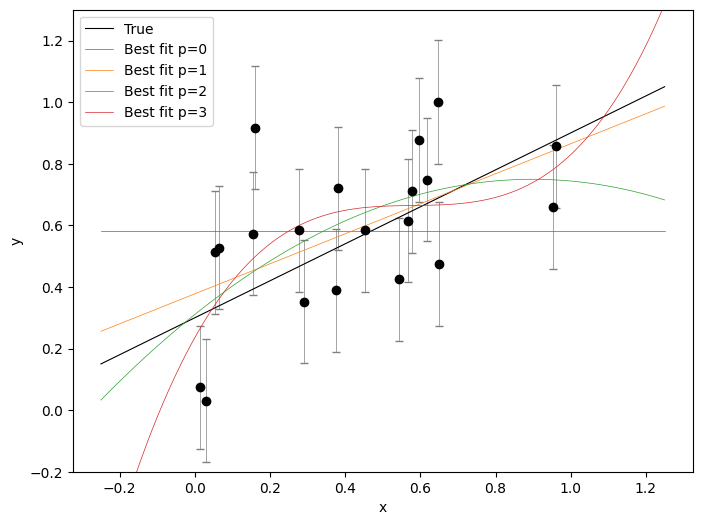

In [9]:
xplot = np.linspace(-0.25, 1.25, 100)
Gplot = getG(xplot, 1)
dplot = np.dot(Gplot, mtrue)
#
plt.figure(figsize=(8, 6))
plt.errorbar(xobs, dobs, yerr=sigma, capsize=3, fmt="ko", ecolor="grey", lw=0.5)
plt.plot(xplot, dplot, label="True", color="k", lw=0.8)
for i in range(maxorder + 1):
    Gplotp = getG(xplot, i)
    dpred = np.dot(Gplotp, mls[i])
    plt.plot(xplot, dpred, label="Best fit p=" + str(i), lw=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-0.2, 1.3)
# plt.savefig('ML_solutions.pdf')
plt.legend()
plt.show()

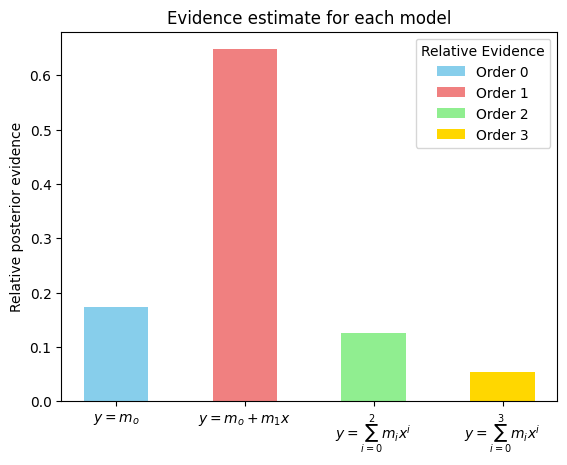

In [10]:
# plot evidence values

fig, ax = plt.subplots()

fruits = [
    r"$y=m_o$",
    r"$y=m_o + m_1x$",
    r"$y = \sum_{i=0}^2 m_ix^i$",
    r"$y = \sum_{i=0}^3 m_ix^i$",
]
counts = [Ev[i] for i in range(maxorder + 1)]
bar_labels = [
    "Order 0",
    "Order 1",
    "Order 2",
    "Order 3",
]  # Define a list of labels, one for each bar

bar_colors = [
    "skyblue",
    "lightcoral",
    "lightgreen",
    "gold",
]  # Define a list of colors, one for each bar

ax.bar(fruits, counts, label=bar_labels, width=0.5, color=bar_colors)

ax.set_ylabel("Relative posterior evidence")
ax.set_title("Evidence estimate for each model")
ax.legend(title="Relative Evidence")
# plt.savefig('Anal_evidence.pdf')

plt.show()

In [11]:
Ev

array([0.17305995, 0.64751747, 0.12509365, 0.05432893])

----------------

Set some global control parameters.

In [12]:
plotting = True  # Create some diagnostic displays of outputs
parallel = False  # Use parallel computation for sampling

### Log-posterior Likeihood, prior and PDF for each state

In [13]:
def _log_likelihood(x, state, dobs, G, Cdinv):
    """Calculate the log likelihood of the data given the model parameters."""
    dpred = np.dot(G[state], x)
    misfit = 0.5 * (np.dot((dobs - dpred), np.dot(Cdinv, (dobs - dpred))))
    f = np.sqrt(2 * np.pi) ** len(dpred)
    detCdinv = np.linalg.det(Cdinv)
    logL = -np.log(f) - misfit + np.log(detCdinv)
    return logL

log_likelihood = partial(_log_likelihood, dobs=dobs, G=G, Cdinv=Cdinv)

In [14]:
def _log_prior(x, state, muprior, Cmprior):
    """Calculate the log prior probability of the model parameters."""
    mu = muprior[state]
    cov = Cmprior[state]
    rv = stats.multivariate_normal(
        mean=mu, cov=cov
    )  # instance of multi-dimensional Gaussian
    return rv.logpdf(x)

log_prior = partial(_log_prior, muprior=muprior, Cmprior=Cmprior)

In [49]:
def log_posterior(x, state):
    """Multi-state log Posterior PDF evaluation (unormalised)."""
    #time.sleep(0.001)
    return log_likelihood(x, state) + log_prior(x, state)

### Starting points for MCMC samplers in each state

In [16]:
# first we optimize each state to find good starting point for all McMC samplers
rng = np.random.default_rng(42)
nstates = maxorder + 1  # Number of distinct states
ndims = [1, 2, 3, 4]  # Number of model parameters in each stateif(True):
nll = lambda *args: -log_posterior(*args)
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = 0.5 * np.ones(i + 1)
    soln = minimize(nll, initial, args=(i,))
    ml.append(soln.x)
    print("x_ml ", soln.x)

Maximum likelihood estimates:
x_ml  [0.58148024]
x_ml  [0.37788932 0.48664354]
x_ml  [ 0.31354801  0.95796058 -0.52400541]
x_ml  [ 0.28548373  1.4395107  -1.83289387  0.89632873]


### Pseudo-prior for each state

Here we use an automatic pseudo prior for each state which corresponds to a best fit multi-dimensional Gaussian to posterior ensembles in each state.

This is built using the function `build_auto_pseudo_prior()` which returns a function which we'll call `log_pseudo_prior()`. 

`build_auto_pseudo_prior()` will conduct some quick initial sampling in each state, and fit a Gaussian Mixture to these samples.

In [17]:
# This generates posterior samples in each state and fits a Gaussian to them to become the pseudo prior
nwalkers_auto = 32  # Number of walkers for auto pseudo prior fitting
nsteps_auto = 1000  # Number of chain steps for auto pseudo prior fitting
autothin = True  # Thin internally generated within state posterior ensembles by their auto-correlation
# (This can take additional compute time, and is not necessary if input ensembles are already independent.)
pos = []
for i in range(nstates):  # generate starting points for each chain in each state
    pos.append(
        ml[i] + 1e-4 * rng.standard_normal((nwalkers_auto, ndims[i]))
    )  # add random perturbation to maximum Likelihood models

sampling_args = {
    "n_states": nstates,
    "n_dims": ndims,
    "n_walkers": nwalkers_auto,
    "n_steps": nsteps_auto,
    "pos": pos,
    "auto_thin": autothin,
    "verbose": False,
}

log_pseudo_prior = build_auto_pseudo_prior(  # noqa: F811
    PseudoPriorBuilders.GAUSSIAN_MIXTURE,
    log_posterior=log_posterior,
    sampling_args=sampling_args,
)

-----------

Now we are ready to apply the three algorithms to sampling over the model states.

## Trans-C samping across model states with the State-Jump sampler 

Here we demonstrate use of the *State-jump sampler*.

This formulation is equivalent to the *Product-space sampler* with the proposal for the other state variables equal to the pseudo prior, for which moves are then accepted with probability one. As a consequence  the only pair of model states that need be considered are the $k$ and $k^{\prime}$ states (i.e. same as in Reversible-Jump). 

- For within-state moves the acceptance is the usual M-H condition with proposal = to users choice for that state, defined by routine `log_proposal`
  This can be any perturbative proposal PDF designed by the user, or an automatic one found by fitting a Gaussian mixture model to some trial samples.

- For between-state moves we assume that only the state index changes, $k \rightarrow k^{\prime}$ , and hence the model in state $k^{\prime}$ must be a draw from the pseduo prior for that state. The acceptance term then only involves the likelihood ratio and the pseudo prior ratio for the two states.


In [18]:
# define model proposal for within state moves


class IsotropicGaussianProposal:
    """Class for isotropic Gaussian proposal for state jump sampler."""

    def __init__(self):
        self.std = [
            [0.01],
            [0.04, 0.05],
            [0.04, 0.2, 0.2],
            [0.05, 0.5, 1.0, 1.0],
        ]  # Proposal variance for each parameter in state

    def __call__(self, x: np.ndarray, state: int) -> float:
        """Call method to generate proposal."""
        return 0.0  # log ratio for symmetric proposal

    def propose(self, x: np.ndarray, state: int) -> np.ndarray:
        """Propose from the proposal distribution."""
        i = rng.choice(np.arange(len(x)))
        var = self.std[state][i] ** 2
        _x = np.copy(x)
        _x[i] += stats.multivariate_normal.rvs(mean=0.0, cov=var)
        if not isinstance(_x, np.ndarray):
            _x = np.array([_x])  # deal with 1D case which returns a scalar
        return _x


log_proposal = IsotropicGaussianProposal()

In [19]:
# starting points of MCMC chains
nwalkers_sj = 32  # Number of walkers
nsteps_sj = 10000  # Number of chain steps
pos_states = rng.choice(
    np.arange(nstates), nwalkers_sj
)  # Initial states of each walker
pos = []
for i in range(nwalkers_sj):  # generate starting points for each walker
    pos.append(
        ml[pos_states[i]] + 1e-4 * rng.standard_normal(ndims[pos_states[i]])
    )  # add random perturbation to maximum Likelihood models

In [20]:
start_time = time.time()
state_jump_chains = run_state_jump_sampler(
    nwalkers_sj,
    nsteps_sj,
    nstates,
    ndims,
    pos,
    pos_states,
    log_posterior,
    log_pseudo_prior,
    log_proposal,
    parallel=parallel,
    progress=True,
)
elapsed_time = time.time() - start_time

alg = "TransC-state-jump-sampler"
state_chain_tot = np.swapaxes(state_jump_chains.state_chain_tot, 0, 1)
state_chain = state_jump_chains.state_chain.T
model_chain = state_jump_chains.model_chain
accept_within_per_walker = (
    state_jump_chains.accept_within / state_jump_chains.prop_within
)
accept_between_per_walker = (
    state_jump_chains.accept_between / state_jump_chains.prop_between
)
accept_within = 100 * np.mean(accept_within_per_walker)
accept_between = 100 * np.mean(accept_between_per_walker)

2025-09-10 18:14:35 [INFO] pytransc.samplers.state_jump: Running state-jump trans-C sampler
2025-09-10 18:14:35 [INFO] pytransc.samplers.state_jump: Number of walkers: 32
2025-09-10 18:14:35 [INFO] pytransc.samplers.state_jump: Number of states being sampled: 4
2025-09-10 18:14:35 [INFO] pytransc.samplers.state_jump: Dimensions of each state: [1, 2, 3, 4]
100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [01:08<00:00,  2.15s/it]


#### Parallelisation
`run_state_jump_sampler` performs posterior sampling over the state space using a Markov chain. The parallelisation pool is exposed in the calling sequence, allowing the user to control the nature of the pool if desired. Here we demonstrate behaviour using a bool, and experiment on execution time as a function of the number of processes.

- `parallel_mode = 0` :Sequential execution (no pool).
- `parallel_mode = 1` :Parallel across states only. Set `n_procs` to a factor of the number of states.

For a more detailed information see the docstring.

In [52]:
parallel_mode = 0

In [60]:
start_time = time.time()
if(parallel_mode==0): # Sequential execution (no pool)
    state_jump_chains = run_state_jump_sampler(
    nwalkers_sj,
    nsteps_sj,
    nstates,
    ndims,
    pos,
    pos_states,
    log_posterior,
    log_pseudo_prior,
    log_proposal,
    parallel=parallel,
    progress=True,
)

elif(parallel_mode ==1): # Demonstrate parallel over 4 processes
    with ProcessPoolExecutor(max_workers=16) as walker_pool:
        state_jump_chains_parallel = run_state_jump_sampler(
            nwalkers_sj,
            nsteps_sj,
            nstates,
            ndims,
            pos,
            pos_states,
            log_posterior,
            log_pseudo_prior,
            log_proposal,
            walker_pool=walker_pool,  # User-provided pool
            progress=True,
        )

elapsed_time = time.time() - start_time
print(
    " Elapsed time                                     :",
    np.round(elapsed_time, 2),
    "s \n",
)

alg = "TransC-state-jump-sampler"
state_chain_tot = np.swapaxes(state_jump_chains.state_chain_tot, 0, 1)
state_chain = state_jump_chains.state_chain.T
model_chain = state_jump_chains.model_chain
accept_within_per_walker = (
    state_jump_chains.accept_within / state_jump_chains.prop_within
)
accept_between_per_walker = (
    state_jump_chains.accept_between / state_jump_chains.prop_between
)
accept_within = 100 * np.mean(accept_within_per_walker)
accept_between = 100 * np.mean(accept_between_per_walker)

2025-09-11 08:24:58 [INFO] pytransc.samplers.state_jump: Running state-jump trans-C sampler
2025-09-11 08:24:58 [INFO] pytransc.samplers.state_jump: Number of walkers: 32
2025-09-11 08:24:58 [INFO] pytransc.samplers.state_jump: Number of states being sampled: 4
2025-09-11 08:24:58 [INFO] pytransc.samplers.state_jump: Dimensions of each state: [1, 2, 3, 4]
100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:51<00:00,  1.60s/it]

 Elapsed time                                     : 51.28 s 



#### Run times for different numbers of processes


| Pool type | Elapsed time (s) | Likelihood Delay (s) | Speedup | Nproc | Nwalkers |Chain length| E1 | E2 | E3 | E4 |
|:-------------|-------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|
| Sequential   | 67.5              | 0 |1    | 1     | 32 | 10000| 0.17922 | 0.64662 | 0.12145 | 0.05271 |
| ProcessPoolExecutor  | 35.4      | 0 |1.91 | 2     | 32 | 10000| 0.17636 | 0.64865 | 0.12173 | 0.05326 |
| ProcessPoolExecutor  | 18.5      | 0 |3.66 | 4     | 32 | 10000| 0.17636 | 0.64865 | 0.12173 | 0.05326 |
| ProcessPoolExecutor  | 9.38      | 0 |7.20 | 8     | 32 | 10000| 0.17636 | 0.64865 | 0.12173 | 0.05326 |
| ProcessPoolExecutor  | 8.77      | 0 |7.70 | 16    | 32 | 10000| 0.17636 | 0.64865 | 0.12173 | 0.05326 |
| Sequential   | 1471.2           | 0.001 |1    | 1     | 32 | 10000| 0.17712 | 0.64522 | 0.12341 | 0.05426 |
| ProcessPoolExecutor  | 657.6     | 0.001 | 2.24 | 2     | 32 | 10000| 0.17712 | 0.64522 | 0.12341 | 0.05426 |
| ProcessPoolExecutor  | 248.7   | 0.001 |5.92 | 4     | 32 | 10000| 0.17712 | 0.64522 | 0.12341 | 0.05426 |
| ProcessPoolExecutor  | 101.9    | 0.001 |14.44 | 8     | 32 | 10000| 0.17712 | 0.64522 | 0.12341 | 0.05426 |
| ProcessPoolExecutor  | 51.3    | 0.001 |28.68| 16    | 32 | 10000|0.17712 | 0.64522 | 0.12341 | 0.05426 |

Relative execution times are dependent on the cost of a Likelihood evaluation. Here a `time.sleep(0.001)` delay has been added to the evaluation of the log-posterior, as noted in the third column to simulate the effect of a computationally expensive forward solver. Speed up values exceed the number of processes for the slower posterior evaluation.

In [61]:
# print some diagnostics
print("\n Algorithm type                                   :", alg)
# extract trans-D samples and chains
discard = 0  # chain burnin
thin = 20  # chain thinning
visits, states_chain = get_visits_to_states(
    transc_sampler=state_jump_chains,
    discard=discard,
    thin=thin,
    normalize=True,
)
visits = visits.swapaxes(0, 1)  # (n_steps, n_walkers, n_states)
states_chain = states_chain.swapaxes(0, 1)  # (n_steps, n_walkers)

state_changes_per_walker = count_state_changes(
    state_jump_chains.state_chain, discard=discard, thin=thin
)
total_state_changes = count_total_state_changes(
    state_jump_chains.state_chain, discard=discard, thin=thin
)
acceptance_rate_between_states = get_acceptance_rate_between_states(
    state_jump_chains, discard=discard, thin=thin
)
autocorr_time_for_between_state_jumps = get_autocorr_between_state_jumps(
    state_jump_chains.state_chain
)
relative_marginal_likelihoods = get_relative_marginal_likelihoods(
    state_jump_chains.state_chain_tot[:, -1, :]
)

print("\n Total number of state changes for all walkers    :", total_state_changes)
print(
    "\n Number of state changes for each walker          :\n",
    *state_changes_per_walker,
)
print(
    "\n Acceptance rates for walkers within states:  \n",
    accept_within_per_walker,
    "\n",
)
print(
    " Acceptance rates for walkers between states: \n",
    accept_between_per_walker,
    "\n",
)
print(
    " Average % acceptance rate for within states      :",
    np.round(accept_within, 2),
)
print(
    " Average % acceptance rate for between states     :",
    np.round(accept_between, 2),
)
print(
    " Auto correlation time for between state sampling :",
    np.round(autocorr_time_for_between_state_jumps, 3),
)
print(" Analytical relative marginal Likelihoods         :", *np.round(Ev, 5))
print(
    " Estimated relative evidences                     :",
    *np.round(relative_marginal_likelihoods, 5),
)
print(
    " Elapsed time.                                    :",
    np.round(elapsed_time, 2),
    "s \n",
)


 Algorithm type                                   : TransC-state-jump-sampler

 Total number of state changes for all walkers    : 6394

 Number of state changes for each walker          :
 203 214 229 203 196 198 190 187 222 205 174 195 218 183 215 172 202 201 184 216 196 190 200 206 192 198 193 215 205 187 205 200

 Acceptance rates for walkers within states:  
 [0.7555605  0.75769657 0.74622558 0.75960471 0.75334523 0.76644846
 0.73962264 0.74986091 0.7475512  0.76248477 0.77555333 0.75387878
 0.75980883 0.76642255 0.76088889 0.78099588 0.75862069 0.74647731
 0.74562181 0.74472808 0.75186713 0.76191534 0.7596058  0.74594354
 0.76273059 0.74416796 0.74894702 0.76123221 0.75205601 0.75982143
 0.77266187 0.75394532] 

 Acceptance rates for walkers between states: 
 [0.39087302 0.42783505 0.41834677 0.38229376 0.4001938  0.37487335
 0.4020202  0.36920039 0.44488189 0.4004128  0.34093162 0.37752161
 0.42472582 0.36740891 0.406      0.3431085  0.34822242 0.40020263
 0.39059305 0.3989899 

In [26]:
nwalkers_sj,nsteps_sj

(32, 10000)

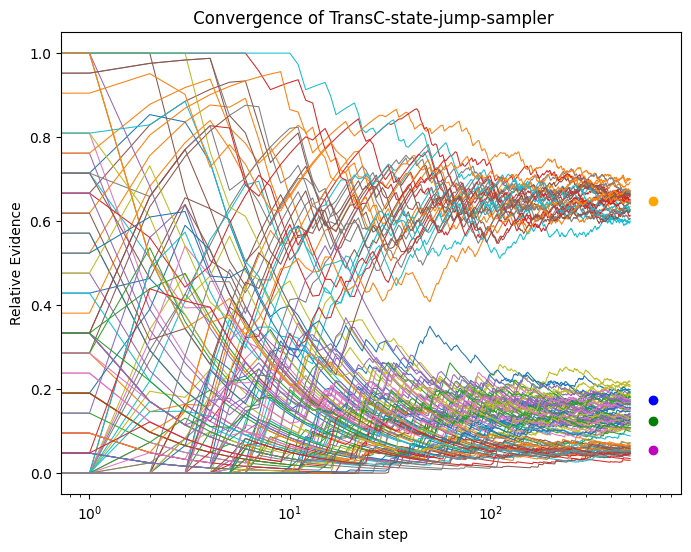

In [22]:
# plot relative number of visits to each state along the chain
if plotting:
    fig, axes = plt.subplots(figsize=(8, 6))
    if visits.ndim == 3:  # plot chains for each state and walker
        plt.semilogx(visits.reshape(np.shape(visits)[0], -1), lw=0.75)
    elif visits.ndim == 2:  # plot chains for each state average over walkers
        plt.semilogx(
            visits.reshape(np.shape(visits)[0], -1),
            lw=0.75,
            label=["State 1", "State 2", "State 3"],
        )
        plt.legend()
    plt.xlabel("Chain step")
    plt.ylabel("Relative Evidence")
    plt.plot(len(visits) * 1.3, Ev[0], "bo")
    plt.plot(len(visits) * 1.3, Ev[1], "o", color="orange")
    plt.plot(len(visits) * 1.3, Ev[2], "go")
    plt.plot(len(visits) * 1.3, Ev[3], "mo")
    plt.title(" Convergence of " + alg)
    # plt.savefig('SJ_chains.pdf')
    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains are 
converging, and visiting each state in proportion to the correct normalization constant. 

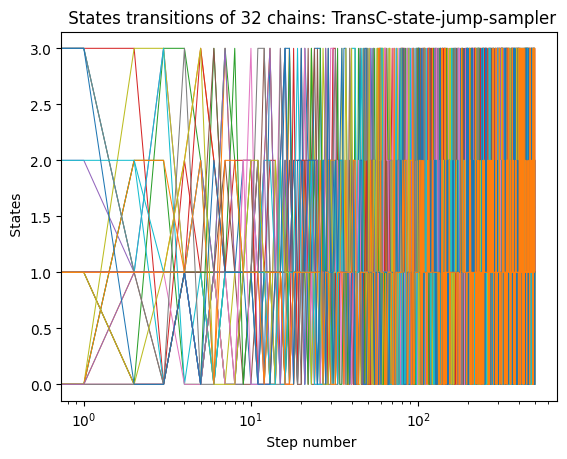

In [23]:
# plot chain states
if plotting:
    # plot chains for each state and walker
    plt.semilogx(states_chain.reshape(np.shape(states_chain)[0], -1), lw=0.75)
    plt.xlabel(" Step number")
    plt.ylabel(" States")
    title = " States transitions of " + str(nwalkers_sj) + " chains: " + alg
    plt.title(title)
    # plt.savefig('SJ_chain_transistions.pdf')
    plt.show()

This plot shows the movement of each chain between states.

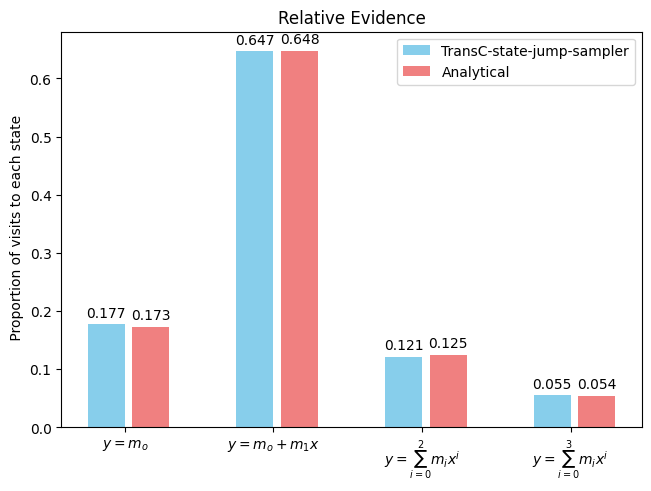

In [24]:
# Count visits to each state by Trans-D mcmc
if plotting:
    h = np.zeros(nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(
        Counter(states_chain.reshape(-1)).values()
    )
    h /= np.sum(h)
    # plot histogram of frequency of visits to each state

    labels = [
        r"$y=m_o$",
        r"$y=m_o + m_1x$",
        r"$y = \sum_{i=0}^2 m_ix^i$",
        r"$y = \sum_{i=0}^3 m_ix^i$",
    ]
    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained")
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h, 3), width, label=alg, color="skyblue")
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier + 0.05
    rects = ax.bar(
        x + offset, np.round(counts, 3), width, label="Analytical", color="lightcoral"
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(" Proportion of visits to each state")
    ax.set_title("Relative Evidence")
    ax.set_xticks(x + width / 2, labels)
    ax.legend(loc="upper right")
    # plt.savefig('SJ_relative_evidences.pdf')
    plt.show()

 State;  1  in  2  dimensions
 State;  2  in  3  dimensions
 State;  3  in  4  dimensions


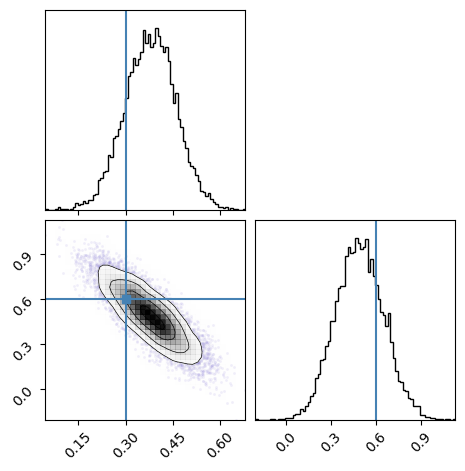

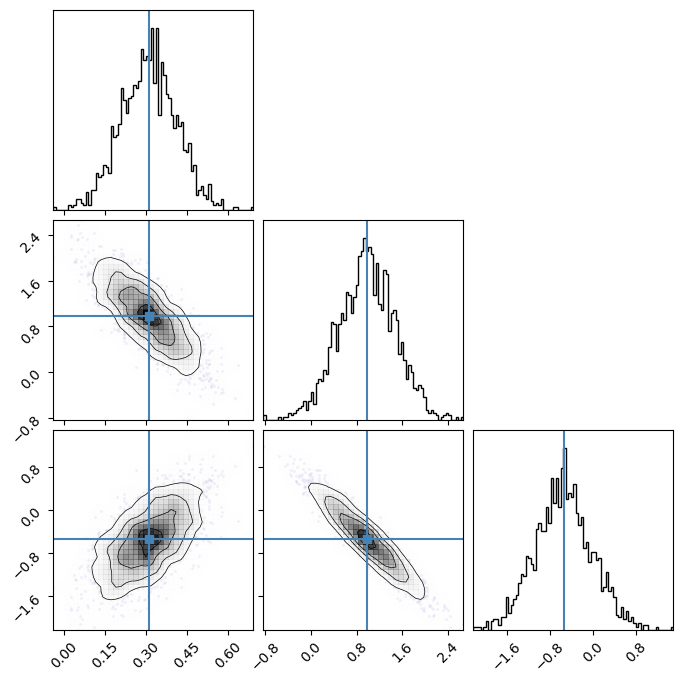

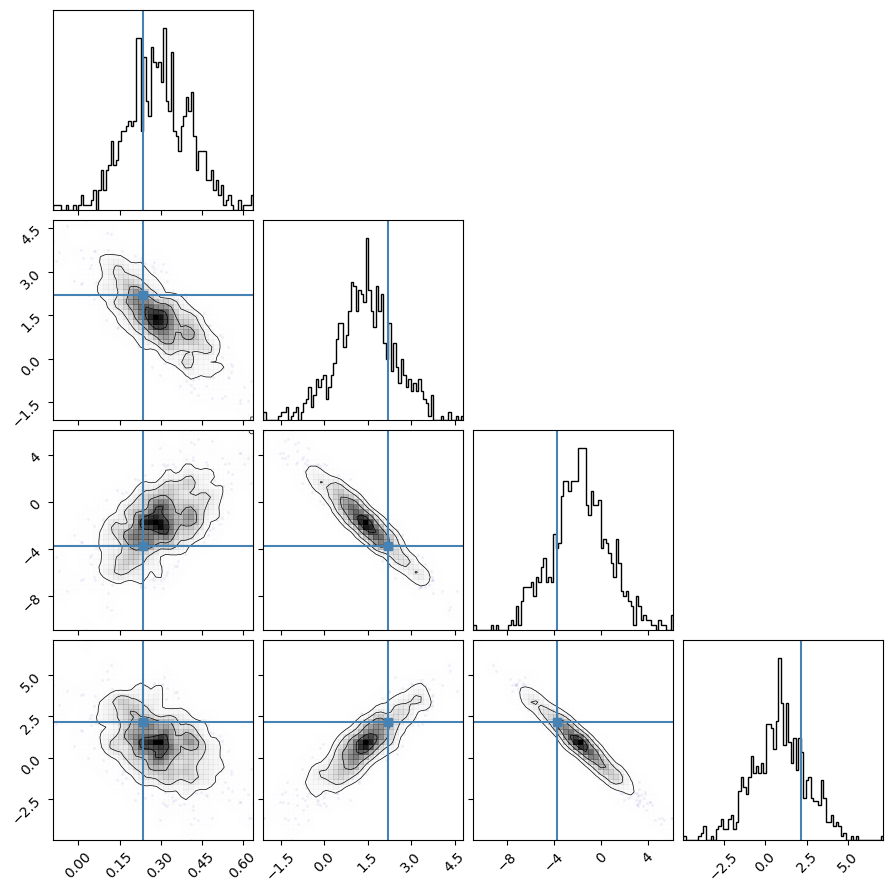

In [25]:
# corner plots to check sampling within each state
if plotting:
    muplot = mls.copy()
    muplot[1] = mtrue
    # collect trans samples
    transc_ensemble = get_transc_samples(
        state_jump_chains,
        discard=0,
        thin=thin,
    )
    contour_kwargs = {"linewidths": 0.5}
    data_kwargs = {"color": "slateblue"}
    for i in range(1, nstates):
        string = "Order " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            transc_ensemble[i],
            truths=muplot[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )
        # fig.savefig("SJ_corner_" + str(i) + ".pdf")

In [26]:
print(
    f" Here is the Trans-C ensemble with\n {len(transc_ensemble[0])} samples in state 1\n {len(transc_ensemble[1])} samples in state 2\n {len(transc_ensemble[2])} samples in state 3\n",
    "\n",
    transc_ensemble,
)

 Here is the Trans-C ensemble with
 2837 samples in state 1
 10353 samples in state 2
 1935 samples in state 3
 
 [array([[0.58822522],
       [0.60757145],
       [0.62142215],
       ...,
       [0.62754262],
       [0.64703905],
       [0.54650348]], shape=(2837, 1)), array([[0.19852337, 0.6807986 ],
       [0.18077874, 0.79599868],
       [0.21783056, 0.79259728],
       ...,
       [0.3709034 , 0.5812397 ],
       [0.37435035, 0.56271444],
       [0.33092364, 0.41110206]], shape=(10353, 2)), array([[ 0.31342636,  0.95789347, -0.57940244],
       [ 0.34433726,  1.33597179, -1.02208011],
       [ 0.4205212 ,  0.51742115, -0.17053328],
       ...,
       [ 0.20417441,  1.55052938, -0.99884797],
       [ 0.38887304,  0.29149898,  0.16602879],
       [ 0.15877914,  1.77721444, -1.32037924]], shape=(1935, 3)), array([[ 0.26980728,  1.12500619, -0.9394146 ,  0.40412607],
       [ 0.21218678,  2.06360194, -2.799364  ,  1.31647998],
       [ 0.17036272,  2.06360194, -2.799364  ,  1.3164799

---------